In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Oil and Gas Exploration and Production in the State of Kentucky Shown as Quarter-Mile Cells
Citation: Biewick, L.R., 2008, Oil and Gas Exploration and Production in the State of Kentucky Shown as Quarter-Mile Cells: U.S. Geological Survey data release,   
**https://doi.org/10.5066/P13NZURP.**  
Summary: A cells polygon feature class was created by the U.S. Geological Survey (USGS) to illustrate the degree of exploration, type of production, and distribution of production in the State of Kentucky. Each cell represents a quarter-mile square of the land surface, and the cells are coded to represent whether the wells included within the cell are predominantly oil-producing, gas-producing, both oil and gas-producing, or the type of production of the wells located within the cell is unknown or dry. Data were retrieved from the Kentucky Oil and Gas Well Records database and saved as a shapefile of oil and gas well locations for Kentucky. Cells were developed as a graphic solution to overcome the problem of displaying proprietary well data. No proprietary data are displayed or included in the cell maps. The data are current as of 2005.

In [2]:
shapefile_path = "kycells05g/kycells05g.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())

   CC83XCOORD  CC83YCOORD  CELLSYMB  \
0  -87.612162   37.456436         4   
1  -82.175694   37.456213         2   
2  -84.759818   37.456264         1   
3  -87.105100   37.456329         4   
4  -87.713574   37.456204         4   

                                            geometry  
0  POLYGON ((-87.61633 37.46033, -87.60718 37.459...  
1  POLYGON ((-82.17957 37.46028, -82.17049 37.459...  
2  POLYGON ((-84.76492 37.45312, -84.76384 37.460...  
3  POLYGON ((-87.10924 37.46024, -87.1001 37.4595...  
4  POLYGON ((-87.71775 37.46009, -87.7086 37.4594...  


In [3]:
print("\n--- Shapefile Metadata ---")
print(gdf.info())
print("\n--- Coordinate Reference System (CRS) ---")
print(gdf.crs)
print("\n--- Column Names ---")
print(gdf.columns)
print("\n--- Geometry Type ---")
print(gdf.geom_type.value_counts())
print(f"\nTotal Number of Features: {len(gdf)}")


--- Shapefile Metadata ---
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32478 entries, 0 to 32477
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CC83XCOORD  32478 non-null  float64 
 1   CC83YCOORD  32478 non-null  float64 
 2   CELLSYMB    32478 non-null  int64   
 3   geometry    32478 non-null  geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 1015.1 KB
None

--- Coordinate Reference System (CRS) ---
GEOGCS["DD_NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]

--- Column Names ---
Index(['CC83XCOORD', 'CC83YCOORD', 'CELLSYMB', 'geometry'], dtype='object')

--- Geometry Type ---
Polygon    32478
Name: count, dtype: int64

Total Number of Features: 32478


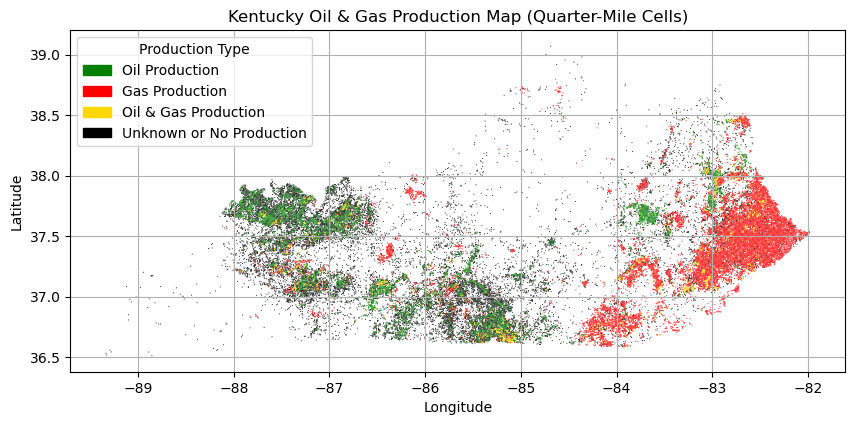

In [4]:
# Define production types and corresponding colors
production_labels = {
    1: "Oil Production",
    2: "Gas Production",
    3: "Oil & Gas Production",
    4: "Unknown or No Production"
}

production_colors = {
    1: "green",
    2: "red",
    3: "gold",
    4: "black"
}

# Plot the oil and gas production map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each category separately
for prod_type, color in production_colors.items():
    subset = gdf[gdf["CELLSYMB"] == prod_type]
    subset.plot(ax=ax, color=color, label=production_labels[prod_type])

# Manually create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(production_labels.values(), production_colors.values())]
ax.legend(handles=legend_patches, loc="upper left", title="Production Type")

# Add titles and labels
ax.set_title("Kentucky Oil & Gas Production Map (Quarter-Mile Cells)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()

In [5]:
import numpy as np
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point

In [6]:

# Extract coordinates and production labels
X = gdf["CC83XCOORD"].values
Y = gdf["CC83YCOORD"].values
labels = gdf["CELLSYMB"].values  # 1: Oil, 2: Gas, 3: Both, 4: Unknown

In [7]:

# Convert categorical labels into indicators
oil_indicator = (gdf['CELLSYMB'] == 1).astype(int)  # 1 if oil, else 0
gas_indicator = (gdf['CELLSYMB'] == 2).astype(int)  # 1 if gas, else 0
both_indicator = (gdf['CELLSYMB'] == 3).astype(int)  # 1 if both, else 0

In [8]:
# Define the kriging grid (extent of the dataset)
grid_x = np.linspace(X.min(), X.max(), 80)  # Adjust resolution if needed
grid_y = np.linspace(Y.min(), Y.max(), 50)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [9]:
# Randomly sample 100 points for each category
np.random.seed(42)  # For reproducibility
sample_size = 1000

In [10]:
def sample_points(X, Y, indicator):
    """Randomly sample points from the dataset while maintaining spatial variability."""
    indices = np.where(indicator == 1)[0]  # Get indices of relevant category
    if len(indices) > sample_size:
        sampled_indices = np.random.choice(indices, sample_size, replace=False)
    else:
        sampled_indices = indices  # Use all available points if less than sample_size
    return X[sampled_indices], Y[sampled_indices], indicator[sampled_indices]

In [11]:
# Sampled points for each category
X_oil, Y_oil, oil_sample = sample_points(X, Y, oil_indicator)
X_gas, Y_gas, gas_sample = sample_points(X, Y, gas_indicator)
X_both, Y_both, both_sample = sample_points(X, Y, both_indicator)

In [12]:
# Ensure valid points (remove NaN and duplicates)
def clean_data(x, y, values):
    """Remove NaN and duplicate points to avoid Kriging errors."""
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(values)
    x, y, values = x[mask], y[mask], values[mask]
    
    unique_points = np.unique(np.column_stack((x, y)), axis=0)
    if len(unique_points) < 5:  # PyKrige needs at least 5 unique points
        print("Not enough unique points for kriging, skipping...")
        return None, None, None
    return x, y, values

In [13]:
X_oil, Y_oil, oil_sample = clean_data(X_oil, Y_oil, oil_sample)
X_gas, Y_gas, gas_sample = clean_data(X_gas, Y_gas, gas_sample)
X_both, Y_both, both_sample = clean_data(X_both, Y_both, both_sample)

In [14]:
# Function to perform ordinary kriging and return both estimate & variance
def perform_kriging(x, y, values, grid_x, grid_y, var_model="linear", var_nugg=0.1, var_range=4, var_sill=0.99, var_slope=0.3):
    """Perform Indicator Kriging on sampled data and return interpolated probabilities & variance."""
    if x is None or len(x) < 5:  # Skip if not enough data
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)
    
    try:
        if var_model == "linear":
            OK = OrdinaryKriging(
                x, y, values,
                variogram_model="linear",
                variogram_parameters={"slope": 0.3, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False, pseudo_inv=True
        )
        else:
            OK = OrdinaryKriging(
                x, y, values,
                variogram_model="gaussian", 
                variogram_parameters={"sill": var_sill, "range": var_range, "nugget": var_nugg},  # Manual parameters
                verbose=False, enable_plotting=False, pseudo_inv=True
        )
        z_pred, ss = OK.execute("grid", grid_x, grid_y)
        return z_pred, ss
    except ValueError as e:
        print(f"Kriging failed: {e}")
        return np.full((len(grid_y), len(grid_x)), np.nan), np.full((len(grid_y), len(grid_x)), np.nan)

In [15]:
# Function to plot probability and uncertainty for a given resource type (stacked vertically)
def plot_probability_uncertainty(grid_x, grid_y, prob, var, title_prob, title_var, cmap_prob, cmap_var):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # Stack plots vertically

    # Probability Map (Top)
    ax = axes[0]
    c_prob = ax.contourf(grid_x, grid_y, prob, cmap=cmap_prob, levels=20)
    plt.colorbar(c_prob, ax=ax, label="Probability")
    ax.set_title(title_prob)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Uncertainty Map (Bottom)
    ax = axes[1]
    c_var = ax.contourf(grid_x, grid_y, var, cmap=cmap_var, levels=20)
    plt.colorbar(c_var, ax=ax, label="Uncertainty (Variance)")
    ax.set_title(title_var)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

In [19]:
def normalize_probabilities(prob):
    """
    Normalize probabilities to the range [0, 1].

    Parameters:
    - prob: 2D array of kriging probability estimates.

    Returns:
    - Normalized probabilities in the range [0, 1].
    """
    prob_min = np.min(prob)
    prob_max = np.max(prob)

    # Avoid division by zero if all values are the same
    if prob_max - prob_min == 0:
        return np.zeros_like(prob)

    return (prob - prob_min) / (prob_max - prob_min)

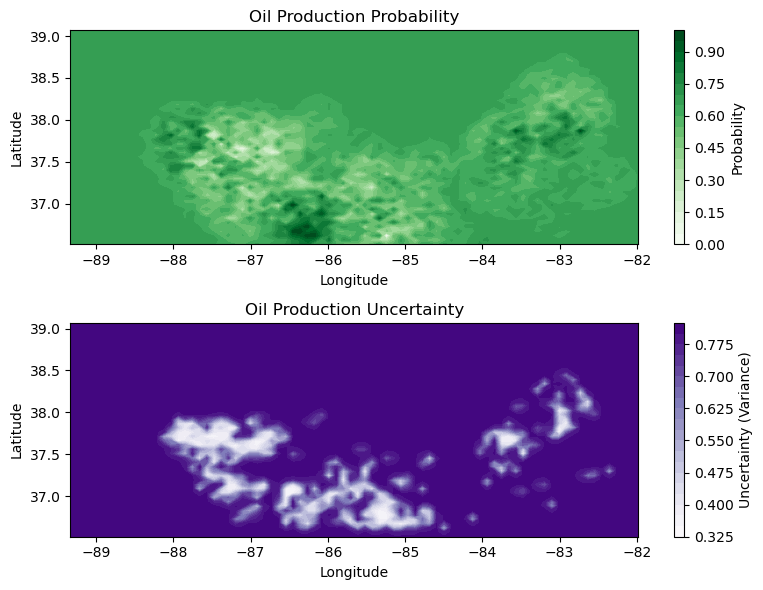

In [20]:
# Run kriging interpolation for oil production
oil_prob, oil_var = perform_kriging(X_oil, Y_oil, oil_sample, 
                                    grid_x, grid_y, 
                                    var_model="gaussian", var_nugg=0.3, 
                                    var_range=0.1, var_sill=0.8)

# Normalize probability values
oil_prob = normalize_probabilities(oil_prob)

# Plot the normalized probability and uncertainty maps
plot_probability_uncertainty(grid_x, grid_y, oil_prob, oil_var, 
                             "Oil Production Probability", "Oil Production Uncertainty", 
                             cmap_prob="Greens", cmap_var="Purples")

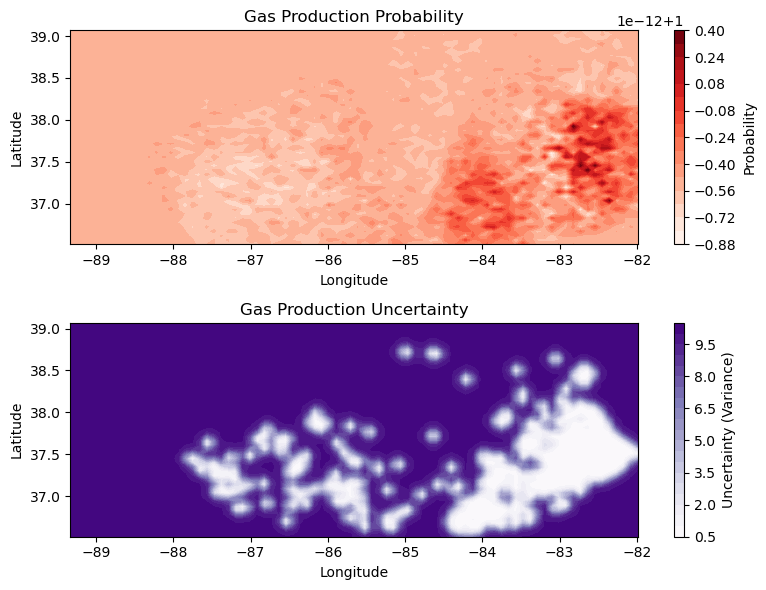

gas probability max/min [np.float64(0.0), np.float64(1.0)]


In [21]:
gas_prob, gas_var = perform_kriging(X_gas, Y_gas, gas_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)
plot_probability_uncertainty(grid_x, grid_y, gas_prob, gas_var, 
                             "Gas Production Probability", "Gas Production Uncertainty", 
                             cmap_prob="Reds", cmap_var="Purples")

# Normalize probability values
gas_prob = normalize_probabilities(gas_prob)

print("gas probability max/min", [gas_prob.min(), gas_prob.max()])

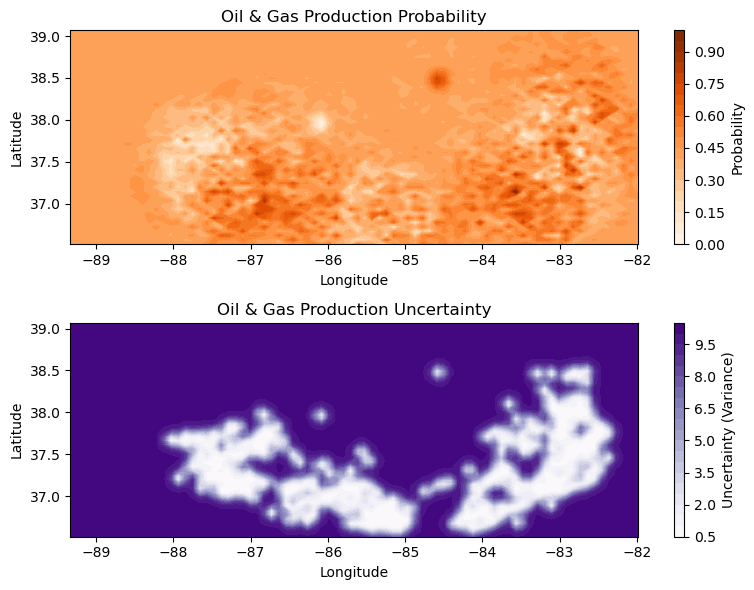

In [22]:
both_prob, both_var = perform_kriging(X_both, Y_both, both_sample, grid_x, grid_y, var_model="gaussian", var_nugg=0.5, var_range=0.2, var_sill=10)

# Normalize probability values
both_prob = normalize_probabilities(both_prob)

plot_probability_uncertainty(grid_x, grid_y, both_prob, both_var, 
                             "Oil & Gas Production Probability", "Oil & Gas Production Uncertainty", 
                             cmap_prob="Oranges", cmap_var="Purples")